# Import modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from PIL import Image
import torch
import copy
import torchmetrics
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from pprint import pformat
from torch.optim import lr_scheduler
from collections import defaultdict
from torchvision import datasets, transforms, models
from torch.utils.data.dataset import Dataset
from torch.utils.data import Subset, random_split
from torchvision.datasets.utils import download_url, extract_archive


# Download dataset

In [2]:
root = './'
filename = 'data.zip'
archive = os.path.join(root, filename)
url = 'https://sid.erda.dk/share_redirect/heaAFNnmaG/data.zip'
data_folder = os.path.join(root, 'data/images')
force_download = False
if (not os.path.exists(data_folder) or force_download):
    download_url(url, root, filename)
    extract_archive(archive, './data', False)

# Import dataset as torch tensors

In [3]:
def imshow(img):
    plt.figure()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])
    plt.show()

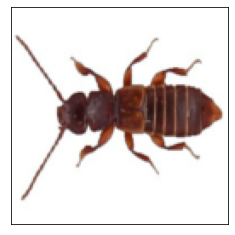

In [4]:
img_height = 128
img_width = img_height
resize_transform = transforms.Resize((img_height, img_width))
pil_transforms = transforms.Compose(
    [resize_transform, transforms.ToTensor()]
)

dataset = datasets.ImageFolder(data_folder, transform=pil_transforms)
image, label = dataset[5]
imshow(image)

# Split dataset into train, validation and test sets

In [5]:
train_len = int(0.8 * len(dataset))
val_len = int(0.1 * len(dataset))
test_len = len(dataset) - (train_len + val_len)
dataset_lengths = [train_len, val_len, test_len]
dataset_sizes = {'train': train_len, 'val': val_len, 'test': test_len}
train_data, val_data, test_data = random_split(dataset, dataset_lengths)
num_workers = 0
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                            num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                            num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                            num_workers=num_workers)
data_loaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}


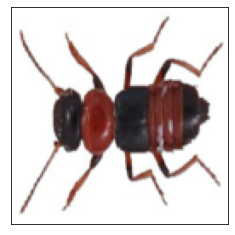

In [6]:
iterable = iter(train_loader)
images, labels = next(iterable)
imshow(images[5])

# Define the classification model

In [8]:
# start by setting up device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# now use resnet18 pretrained with last layer replaced
model = models.resnet18(pretrained=True)
num_fc = model.fc.in_features
# were just counting the number of classes by counting subfolders in image folder
num_classes = len(next(os.walk(data_folder))[1])
model.fc = nn.Linear(num_fc, num_classes)
model = model.to(device)
# what kind of objective will we be using for our classification?
# we are dealing with multiclass classification so cross entropy loss makes sense
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized (i.e. all layers are unfrozen)
# using stochastic gradient descent
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Train the model

In [9]:
def train_model(model, data_loaders, dataset_sizes, criterion, 
                optimizer, scheduler, num_epochs=100, device="cuda:0"):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    epochs = np.arange(num_epochs)
    metrics = np.empty((num_epochs, 5))
    metrics[:,0] = epochs

    for epoch in epochs:
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
                metrics[epoch, 1] = epoch_loss
                metrics[epoch, 2] = epoch_acc
            else:
                metrics[epoch, 3] = epoch_loss
                metrics[epoch, 4] = epoch_acc

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
        print()
        print(metrics[epoch])
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, metrics


In [10]:
model, metrics = train_model(model, data_loaders, dataset_sizes,criterion, 
                    optimizer,  exp_lr_scheduler, 
                    num_epochs=100, device = device)

Epoch 0/99
----------


C:\Users\Jacki\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 3.3933 Acc: 0.2996
val Loss: 2.1743 Acc: 0.4874

[0.         3.39328432 0.29960425 2.17430962 0.48740101]
Epoch 1/99
----------
train Loss: 1.5149 Acc: 0.6678
val Loss: 1.2116 Acc: 0.6940

[1.         1.51490926 0.66783594 1.21162593 0.69402448]
Epoch 2/99
----------
train Loss: 0.8272 Acc: 0.8283
val Loss: 0.9311 Acc: 0.7595

[2.         0.82720834 0.82829646 0.93112708 0.75953924]
Epoch 3/99
----------
train Loss: 0.4933 Acc: 0.9196
val Loss: 0.8864 Acc: 0.7703

[3.         0.49331886 0.91958985 0.88640539 0.77033837]
Epoch 4/99
----------
train Loss: 0.3080 Acc: 0.9638
val Loss: 0.7494 Acc: 0.8071

[4.         0.30797802 0.96384242 0.74937701 0.80705544]
Epoch 5/99
----------
train Loss: 0.1965 Acc: 0.9840
val Loss: 0.7058 Acc: 0.8222

[5.         0.19647791 0.98398993 0.70584508 0.82217423]
Epoch 6/99
----------
train Loss: 0.1285 Acc: 0.9944
val Loss: 0.6193 Acc: 0.8416

[6.         0.12850157 0.99442346 0.61925259 0.84161267]
Epoch 7/99
----------
train Loss: 0.0956 A

# Save trained model and metrics

In [13]:
if not os.path.exists('data/models'):
    os.makedirs('data/models')
torch.save(model.state_dict(), 'data/models/model_0_parameters.pt')
torch.save(model, 'data/models/model_0.pt')
np.save('data/models/model_0_metrics', metrics)

# plot metrics

In [65]:
def multiplot(systems, x_axis, y_axis, labels, name, title=None, dpi=200):
    plt.figure()
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    for i in range(len(systems)):
        plt.plot(systems[i, 0], systems[i, 1], label=labels[i])
        plt.title(title, pad = 20)
    plt.legend()
    plt.grid()
    plt.savefig('figures/'+name,  bbox_inches='tight', facecolor='w', dpi=dpi)
    plt.show()
    plt.close()


In [66]:
epochs = metrics[:,0]
remaining_metrics = metrics[:,1:]
np.array([epochs, remaining_metrics[:,0]])
systems = np.array([[epochs, metric] for metric in remaining_metrics.T])
systems.shape
if not os.path.exists('figures'):
    os.makedirs('figures')

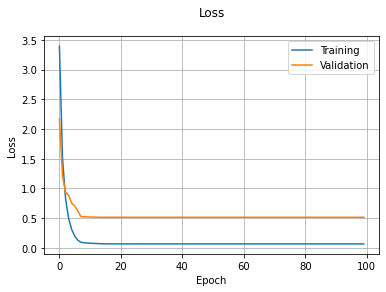

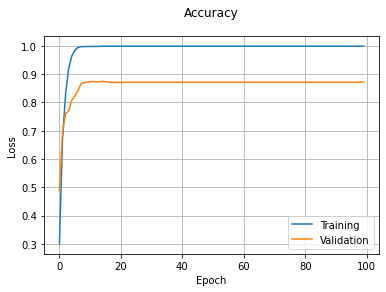

In [67]:
labels = ['Training', 'Validation']
name = 'loss_comparison.pdf'
multiplot(systems[[0,2]], 'Epoch', 'Loss', labels, name, 'Loss')
labels = ['Training', 'Validation']
name = 'accuracy_comparison.pdf'
multiplot(systems[[1, 3]], 'Epoch', 'Loss', labels, name, 'Accuracy')

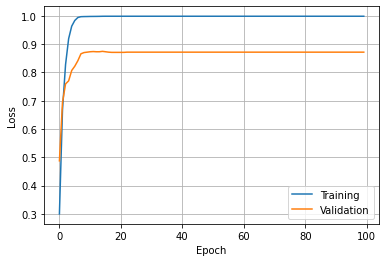